In [6]:
import torch
import numpy as np
from torchvision.transforms import transforms as T
import torch.nn as nn
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
sys.path.append('..')
sys.path.append('../dataset_loader')
sys.path.append('../model')
from config import *

In [2]:
from dataset_loader.image_loader import *
from model.resunet import *
from utils import *

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [4]:
model = nn.DataParallel(c_resunetVAE(arch='c-ResUnetVAE', n_features_start = 16, n_out = 1,
        pretrained = False, progress= True)).to(device)
model.load_state_dict(torch.load('../model_results_torch/2path_2head.h5.h5'))

Initializing conv2d weights with Kaiming He normal


<All keys matched successfully>

In [74]:
test = True
priority_list = ['254.tiff', '275.tiff', '81.tiff', '278.tiff']

In [75]:
transform = T.Compose([T.Lambda(lambda x: x * 1. / 255),
                       T.ToTensor(),
                       #T.Resize((1040,1400))
                      #T.Lambda(lambda x: x.permute(2, 0, 1))
                       ])
cells_images = CellsLoader(root + "/DATASET/test/all_images/images/",
                           root + "/DATASET/test/all_masks/masks/", 
                           val_split=0.3, transform = transform, test = test, priority_list=priority_list)

#cells_images = CellsLoader(root + "/DATASET/test/all_images/red/",
#                           root + "/DATASET/test/all_masks/red/", 
#                           val_split=0.3, transform = transform, ae = ae, test = test)

#cells_images = CellsLoader(root + "/DATASET/train_val/crop_augmented/images/",
#                           root + "/DATASET/train_val/crop_augmented/masks/", 
#                           val_split=0.3, transform = transform, ae = ae, test = False)

In [76]:
batch_size = 4
test_loader = DataLoader(cells_images, batch_size=batch_size)

In [77]:
x, y = next(iter(test_loader))

In [78]:
x.size()

torch.Size([4, 3, 1200, 1600])

In [19]:
y.size()

torch.Size([1, 3, 1200, 1600])

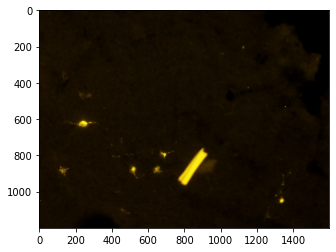

In [21]:
plt.imshow(x[0].permute(1,2,0))

In [26]:
vae = True
ae =False

In [97]:
model.eval()
with torch.no_grad():
    if vae:
        mu, sigma, segm, (mu_p, sigma_p) = model(x.to(device))
        recon_loss, au, ne, au_1ch, ne_1ch = loss_VAE_rec(mu_p.to(device), sigma_p.to(device), x.to(device))
        heatmap = segm
        uncertanties = ne_1ch.cpu().detach()
        #uncertanties = mu_p
    else:
        heatmap = model(x.to(device))
    if ae:
        ae_image=heatmap

In [86]:
uncertanties[0].shape

torch.Size([1200, 1600])

In [29]:
y.size()

torch.Size([1, 3, 1200, 1600])

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

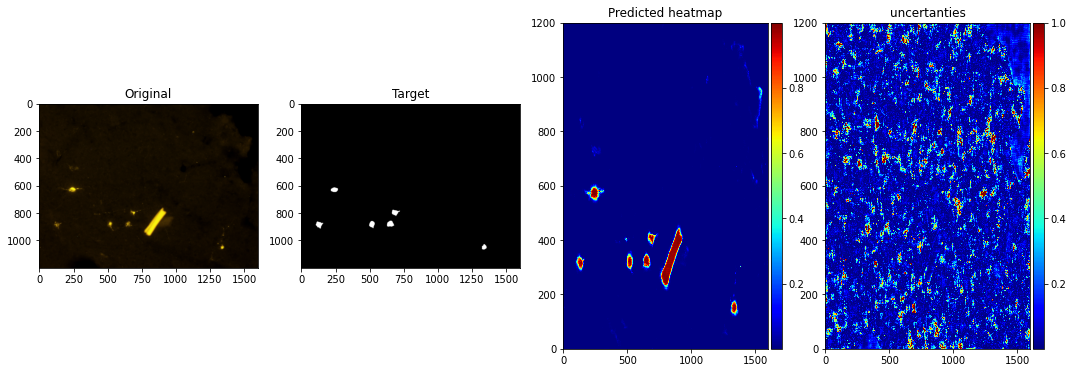

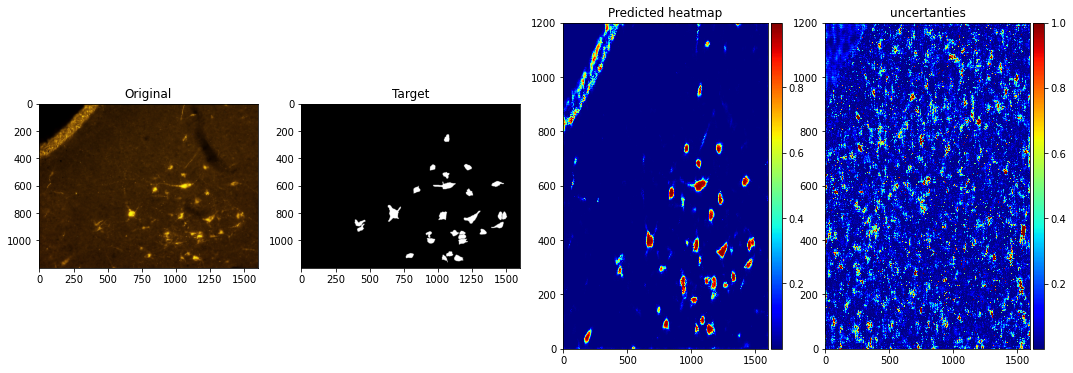

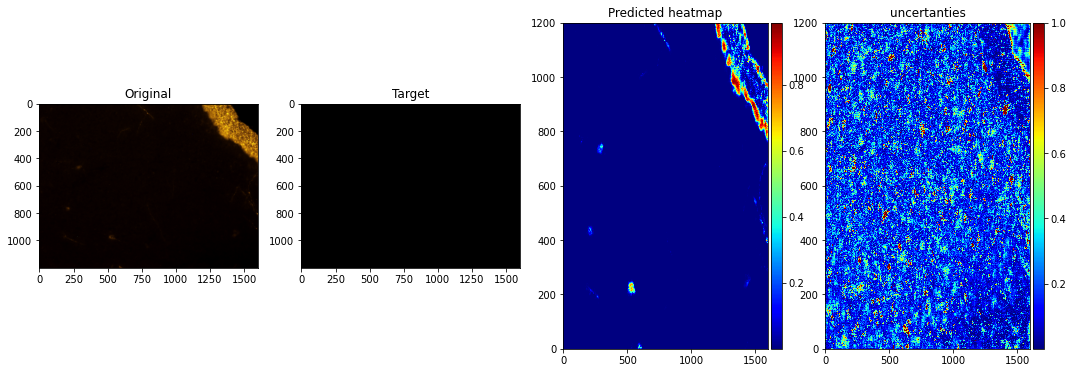

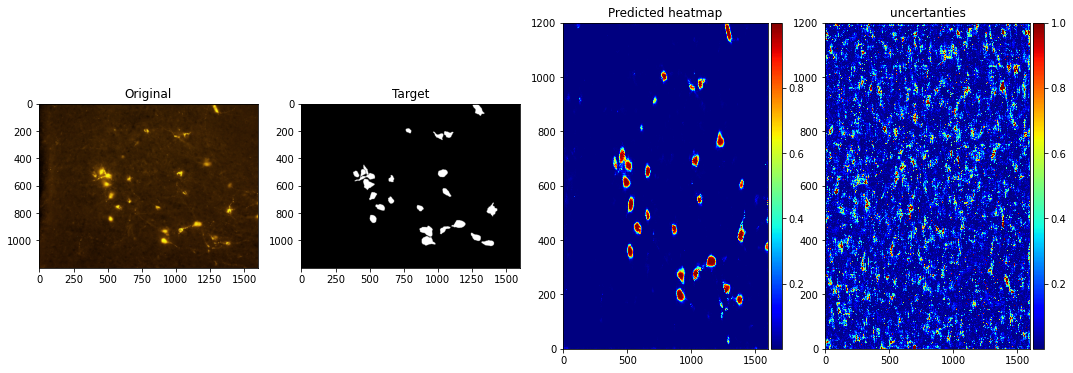

In [98]:
for i in range(heatmap.size()[0]):
    
#     print(test_ids[i+start])
    original = x[i].permute(1,2,0)
    target = y[i].permute(1,2,0)
    heat_map = heatmap[i]
    unc = uncertanties[i]

    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    
    if ae:
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow((target), cmap='gray')
        axes[1].set_title('Target')
        
        im = axes[2].imshow((heat_map.permute(1,2,0).cpu().detach()))
        axes[2].set_title('Predicted heatmap') 
        
    else:        
       
        im = axes[0].imshow(original)
        axes[0].set_title('Original')

        im = axes[1].imshow(np.squeeze(target), cmap='gray')
        axes[1].set_title('Target')
    
        im = axes[2].pcolormesh(np.flipud(heat_map.cpu().detach().squeeze()), cmap='jet')
        divider = make_axes_locatable(axes[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        axes[2].set_title('Predicted heatmap') 
        
        if len(unc.shape) > 3 :
            im = axes[3].imshow(unc.cpu().detach())
            axes[3].set_title('Original')
            
        else:
            im = axes[3].pcolormesh(np.flipud(np.clip(unc.squeeze()/np.quantile(unc, 0.99),0,1)), cmap='jet')
            divider = make_axes_locatable(axes[3])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(im, cax=cax)
            axes[3].set_title('uncertanties') 


In [91]:
unc.shape

torch.Size([1200, 1600])